Notebook to replicate the topological analysis of OOD examples from the paper
"Topology of Out-of-Distribution Examples in Deep Neural Networks".

This notebook performs the following steps:
1. Load pre-trained ResNet18 models and adapt them for MNIST/CIFAR-10.
2. Load MNIST, EMNIST, CIFAR-10, CIFAR-100 datasets.
3. Extract embeddings from the penultimate layer.
4. Implement bootstrapping to compute persistent homology (H0, H1) on subsamples.
5. Calculate average and maximum lifetime statistics for topological features.
6. Plot distributions of these statistics for In-Distribution (ID) Train/Test
   and Out-of-Distribution (OOD) data.

In [ ]:
!pip install ripser

## 1. Setup and Imports

Import necessary libraries. Make sure you have installed `torch`, `torchvision`, `numpy`, `matplotlib`, `ripser`, `tqdm`, and `scikit-learn`.
 ```bash
pip install torch torchvision numpy matplotlib ripser tqdm scikit-learn cython
```

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ripser import ripser
from tqdm.notebook import tqdm
import random
import warnings
import os

In [ ]:
# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Create directories for plots if they don't exist
os.makedirs("plots", exist_ok=True)


Using device: cuda


## 2. Configuration Parameters

Define parameters for the analysis, such as dataset sizes, bootstrap iterations, and sample sizes.
**Note:** The paper uses 50,000 iterations and sample sizes up to 150. These values are reduced here for faster execution. Increase them for more accurate replication.

In [ ]:
N_SAMPLES_EMBEDDING = 5000 # Number of samples to extract embeddings from for each dataset split (Train/Test/OOD)
N_ITERATIONS = 50000         # Number of bootstrap iterations
SAMPLE_SIZE = 60          # Size of each bootstrap sample  optimal size is 150
BATCH_SIZE = 128           # Batch size for data loading and embedding extraction
MAX_DIM_HOMOLOGY = 1       # Maximum homology dimension (H0, H1)

## 3. Model Loading and Adaptation
Load a pre-trained ResNet18 model and adapt its first convolutional layer (for MNIST grayscale) and final fully connected layer for the number of classes in each dataset. We will also define a hook to extract features from the penultimate layer.

In [ ]:
def get_resnet18_model(num_classes, grayscale=False, pretrained=True):
    """Loads a ResNet18 model, optionally adapts for grayscale input."""
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

    if grayscale:
        # Adapt the first convolutional layer for 1 input channel (grayscale)
        original_first_layer = model.conv1
        model.conv1 = nn.Conv2d(1, original_first_layer.out_channels,
                                kernel_size=original_first_layer.kernel_size,
                                stride=original_first_layer.stride,
                                padding=original_first_layer.padding,
                                bias=False)
        # Optional: Initialize the new layer's weights, e.g., by averaging the original weights
        if pretrained:
             # Simple averaging of weights across the RGB channels
            model.conv1.weight.data = original_first_layer.weight.data.mean(dim=1, keepdim=True)


    # Adapt the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model.to(device)

# Hook function to capture activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

## 4. Data Loading
Define functions to load MNIST, EMNIST (as OOD for MNIST), CIFAR-10, and CIFAR-100 (as OOD for CIFAR-10).


In [ ]:
def load_mnist_data(batch_size):
    """Loads MNIST train/test and EMNIST test datasets."""
    transform_mnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST mean/std
    ])
    # EMNIST 'letters' split will be used as OOD
    transform_emnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1752,), (0.3346,)) # EMNIST Letters mean/std - adjust if using different split
    ])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
    # Using EMNIST 'letters' as OOD. Ensure the split makes sense for your task.
    ood_dataset = torchvision.datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform_emnist)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    ood_loader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, ood_loader

def load_cifar_data(batch_size):
    """Loads CIFAR-10 train/test and CIFAR-100 test datasets."""
    transform_cifar10 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
    ])
    transform_cifar100 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) # CIFAR-100 mean/std
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)
    ood_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar100) # CIFAR-100 test set as OOD

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    ood_loader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, ood_loader

def load_cifar10_svhn_data(batch_size):
    """Loads CIFAR-10 train/test and SVHN test datasets."""
    print("Loading CIFAR-10/SVHN datasets...")
    transform_cifar10 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
    ])
    # SVHN normalization constants (commonly used)
    transform_svhn = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)) # SVHN mean/std
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)
    # Use SVHN test set as OOD
    ood_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    ood_loader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=False)
    print("CIFAR-10/SVHN datasets loaded.")
    return train_loader, test_loader, ood_loader

## 5. Embedding Extraction Function
This function takes a model and a data loader, runs the data through the model, and extracts the embeddings from the layer specified by the hook.


In [ ]:

def extract_embeddings(model, data_loader, hook_handle, target_layer_name, n_samples, desc="Extracting"):
    """Extracts embeddings from the target layer for a subset of data."""
    model.eval()
    embeddings = []
    labels = []
    count = 0
    with torch.no_grad():
        for images, lbls in tqdm(data_loader, desc=f"{desc} Embeddings", leave=False):
            if count >= n_samples:
                break
            images = images.to(device)
            # Ensure grayscale images have the correct channel dimension if needed by model
            if images.shape[1] == 1 and model.conv1.in_channels == 3:
                 images = images.repeat(1, 3, 1, 1) # Convert grayscale to pseudo-RGB
            elif images.shape[1] == 3 and model.conv1.in_channels == 1:
                 # This case shouldn't happen with standard datasets/models but added for robustness
                 images = images[:, 0:1, :, :] # Take only one channel

            _ = model(images) # Forward pass to trigger hook
            batch_embeddings = activation[target_layer_name].cpu().numpy()

            # Flatten the embeddings if they are not already flat (e.g., output of avgpool)
            if batch_embeddings.ndim > 2:
                batch_embeddings = batch_embeddings.reshape(batch_embeddings.shape[0], -1)

            embeddings.append(batch_embeddings)
            labels.append(lbls.cpu().numpy())
            count += len(images)

    hook_handle.remove() # Clean up the hook
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Trim to exact n_samples if we overshot
    if embeddings.shape[0] > n_samples:
        embeddings = embeddings[:n_samples]
        labels = labels[:n_samples]

    print(f"Extracted {embeddings.shape[0]} embeddings of dimension {embeddings.shape[1]}")
    return embeddings, labels

## 6. Persistent Homology Computation Function

This function takes a data sample (point cloud), computes its persistent homology using `ripser`, and calculates summary statistics (average/maximum lifetime for $H_0$ and $H_1$).


In [ ]:
def compute_ph_stats(sample_data, max_dim=1):
    """Computes persistent homology and lifetime statistics."""
    if sample_data.shape[0] < 2: # Need at least 2 points for ripser
        return {
            'avg_lifetime_h0': np.nan, 'max_lifetime_h0': np.nan,
            'avg_lifetime_h1': np.nan, 'max_lifetime_h1': np.nan
        }

    # Compute persistence diagrams using ripser
    # Using distance_matrix='euclidean' can sometimes be faster if points are high-dim
    # but ripser handles point clouds directly too.
    # Setting `metric='euclidean'` explicitly
    try:
        result = ripser(sample_data, maxdim=max_dim, metric='euclidean')
        dgms = result['dgms']
    except Exception as e:
        print(f"Ripser computation failed: {e}")
        print(f"Sample shape: {sample_data.shape}")
         # Return NaNs or default values if ripser fails
        return {
            'avg_lifetime_h0': np.nan, 'max_lifetime_h0': np.nan,
            'avg_lifetime_h1': np.nan, 'max_lifetime_h1': np.nan
        }


    stats = {}

    # Process H0 (Dimension 0 - Connected Components)
    dgm_h0 = dgms[0]
    # Lifetimes: death - birth. Birth is always 0 for H0.
    # Exclude the infinite bar [0, inf] which represents the single final component.
    lifetimes_h0 = dgm_h0[:, 1] - dgm_h0[:, 0]
    finite_lifetimes_h0 = lifetimes_h0[np.isfinite(lifetimes_h0)]

    if len(finite_lifetimes_h0) > 0:
        stats['avg_lifetime_h0'] = np.mean(finite_lifetimes_h0)
        stats['max_lifetime_h0'] = np.max(finite_lifetimes_h0)
    else:
        stats['avg_lifetime_h0'] = 0 # Or np.nan, depending on desired handling
        stats['max_lifetime_h0'] = 0 # Or np.nan

    # Process H1 (Dimension 1 - Loops/Holes) if computed
    if max_dim >= 1 and len(dgms) > 1:
        dgm_h1 = dgms[1]
        if len(dgm_h1) > 0:
            # Lifetimes: death - birth
            lifetimes_h1 = dgm_h1[:, 1] - dgm_h1[:, 0]
            # Handle potential infinite death times if any (unlikely for H1 with finite data)
            finite_lifetimes_h1 = lifetimes_h1[np.isfinite(lifetimes_h1)]
            if len(finite_lifetimes_h1) > 0:
                stats['avg_lifetime_h1'] = np.mean(finite_lifetimes_h1)
                stats['max_lifetime_h1'] = np.max(finite_lifetimes_h1)
            else:
                 stats['avg_lifetime_h1'] = 0 # Or np.nan
                 stats['max_lifetime_h1'] = 0 # Or np.nan
        else:
            stats['avg_lifetime_h1'] = 0 # No H1 features found
            stats['max_lifetime_h1'] = 0
    else:
        # Assign default values if H1 was not computed or no diagram exists
        stats['avg_lifetime_h1'] = np.nan
        stats['max_lifetime_h1'] = np.nan


    return stats

## 7. Bootstrapping Function

This function performs the bootstrapping process: repeatedly samples from the full set of embeddings, computes PH statistics for each sample, and collects the results.


In [ ]:
def run_bootstrap_analysis(all_embeddings, n_iterations, sample_size, max_dim=1, desc="Bootstrapping"):
    """Performs bootstrapping to get distributions of PH statistics."""
    results = {
        'avg_lifetime_h0': [], 'max_lifetime_h0': [],
        'avg_lifetime_h1': [], 'max_lifetime_h1': []
    }
    n_total = all_embeddings.shape[0]

    if n_total < sample_size:
        print(f"Warning: Number of embeddings ({n_total}) is less than sample size ({sample_size}). Skipping bootstrap for {desc}.")
        # Fill results with NaNs or appropriate defaults
        for key in results:
            results[key] = [np.nan] * n_iterations
        return results


    for _ in tqdm(range(n_iterations), desc=f"{desc} (Size {sample_size})", leave=False):
        # Sample indices with replacement
        indices = np.random.choice(n_total, sample_size, replace=True)
        sample = all_embeddings[indices]

        # Compute PH stats for the sample
        stats = compute_ph_stats(sample, max_dim=max_dim)

        # Store results
        for key in results.keys():
            if key in stats:
                results[key].append(stats[key])
            else:
                results[key].append(np.nan) # Append NaN if stat wasn't computed

    # Convert lists to numpy arrays
    for key in results.keys():
        results[key] = np.array(results[key])

    return results

## 8. Plotting Function
This function plots the distributions of the collected statistics (e.g., average $H_0$ lifetime) for Train, Test, and OOD data, including 95% confidence intervals.


In [ ]:
def plot_distributions(results_train, results_test, results_ood, statistic_key, dataset_name, sample_size, filename_suffix):
    """Plots the distributions of a specific PH statistic for Train, Test, OOD."""

    plt.figure(figsize=(10, 6))
    sns.histplot(results_train[statistic_key], color='black', label=f'Train (ID)', kde=True, stat='density', alpha=0.6)
    sns.histplot(results_test[statistic_key], color='blue', label=f'Test (ID)', kde=True, stat='density', alpha=0.6)
    sns.histplot(results_ood[statistic_key], color='red', label=f'OOD', kde=True, stat='density', alpha=0.6)

    # Calculate 95% confidence intervals
    ci_train = np.percentile(results_train[statistic_key][~np.isnan(results_train[statistic_key])], [2.5, 97.5])
    ci_test = np.percentile(results_test[statistic_key][~np.isnan(results_test[statistic_key])], [2.5, 97.5])
    ci_ood = np.percentile(results_ood[statistic_key][~np.isnan(results_ood[statistic_key])], [2.5, 97.5])

    # Add vertical lines for CIs
    plt.axvline(ci_train[0], color='black', linestyle='--', alpha=0.7)
    plt.axvline(ci_train[1], color='black', linestyle='--', alpha=0.7, label=f'Train 95% CI [{ci_train[0]:.3f}, {ci_train[1]:.3f}]')
    plt.axvline(ci_test[0], color='blue', linestyle='--', alpha=0.7)
    plt.axvline(ci_test[1], color='blue', linestyle='--', alpha=0.7, label=f'Test 95% CI [{ci_test[0]:.3f}, {ci_test[1]:.3f}]')
    plt.axvline(ci_ood[0], color='red', linestyle='--', alpha=0.7)
    plt.axvline(ci_ood[1], color='red', linestyle='--', alpha=0.7, label=f'OOD 95% CI [{ci_ood[0]:.3f}, {ci_ood[1]:.3f}]')

    # Format title and labels
    title_stat = statistic_key.replace('_', ' ').title()
    homology_dim = 'H0' if 'h0' in statistic_key else 'H1'
    plt.title(f'Distribution of {title_stat} ({homology_dim}) - {dataset_name}\nBootstrap Size: {sample_size}, Iterations: {N_ITERATIONS}')
    plt.xlabel("Lifetime Value")
    plt.ylabel("Density")
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()

    # Save the plot
    filename = f"plots/{dataset_name}_{statistic_key}_ss{sample_size}_iter{N_ITERATIONS}_{filename_suffix}.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.show()

## 9. Run Analysis: MNIST vs EMNIST


### 9.1 Load Model and Data (MNIST)

In [ ]:
print("--- Starting MNIST Analysis ---")
# Load model
mnist_model = get_resnet18_model(num_classes=10, grayscale=True, pretrained=True)
# Register hook on the output of the average pooling layer (before FC)
hook_handle_mnist = mnist_model.avgpool.register_forward_hook(get_activation('avgpool_mnist'))
target_layer_mnist = 'avgpool_mnist'

# Load data
mnist_train_loader, mnist_test_loader, emnist_loader = load_mnist_data(BATCH_SIZE)


--- Starting MNIST Analysis ---


 ### 9.2 Extract Embeddings (MNIST)

In [ ]:
print("Extracting MNIST Train embeddings...")
mnist_train_embeddings, _ = extract_embeddings(mnist_model, mnist_train_loader, hook_handle_mnist, target_layer_mnist, N_SAMPLES_EMBEDDING, desc="MNIST Train")
# Re-register hook as it's removed after extraction
hook_handle_mnist = mnist_model.avgpool.register_forward_hook(get_activation(target_layer_mnist))

print("Extracting MNIST Test embeddings...")
mnist_test_embeddings, _ = extract_embeddings(mnist_model, mnist_test_loader, hook_handle_mnist, target_layer_mnist, N_SAMPLES_EMBEDDING, desc="MNIST Test")
hook_handle_mnist = mnist_model.avgpool.register_forward_hook(get_activation(target_layer_mnist))

print("Extracting EMNIST (OOD) embeddings...")
emnist_ood_embeddings, _ = extract_embeddings(mnist_model, emnist_loader, hook_handle_mnist, target_layer_mnist, N_SAMPLES_EMBEDDING, desc="EMNIST OOD")
# Hook is removed automatically by the function


### 9.3 Run Bootstrapping (MNIST)

In [ ]:
print("Running Bootstrap Analysis for MNIST...")
results_mnist_train = run_bootstrap_analysis(mnist_train_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="MNIST Train")
results_mnist_test = run_bootstrap_analysis(mnist_test_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="MNIST Test")
results_emnist_ood = run_bootstrap_analysis(emnist_ood_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="EMNIST OOD")


 ### 9.4 Plot Results (MNIST)

Plotting MNIST results...
Saved plot: plots/MNIST_avg_lifetime_h0_ss60_iter50000_avg_h0.png


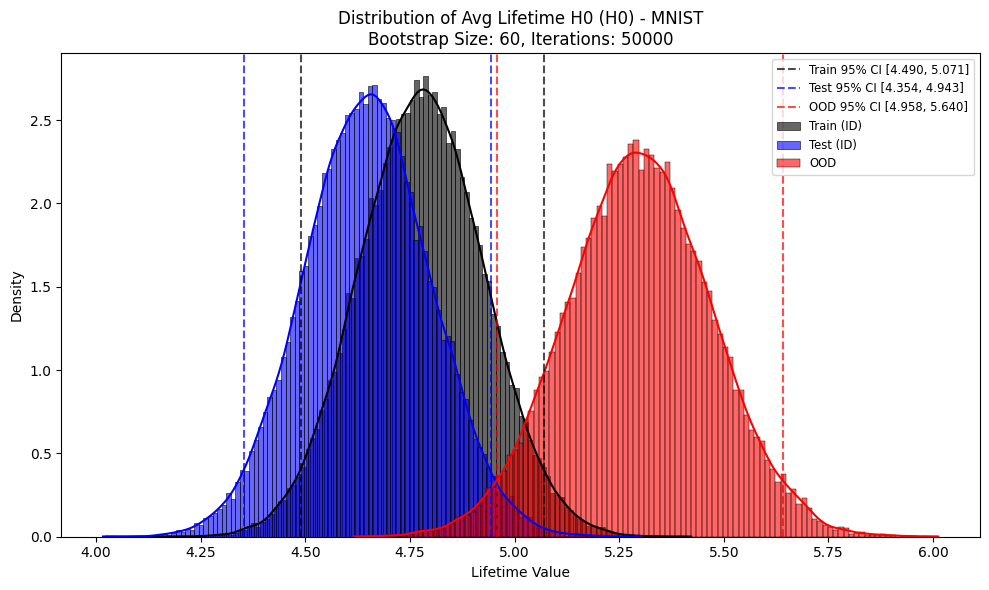

Saved plot: plots/MNIST_max_lifetime_h0_ss60_iter50000_max_h0.png


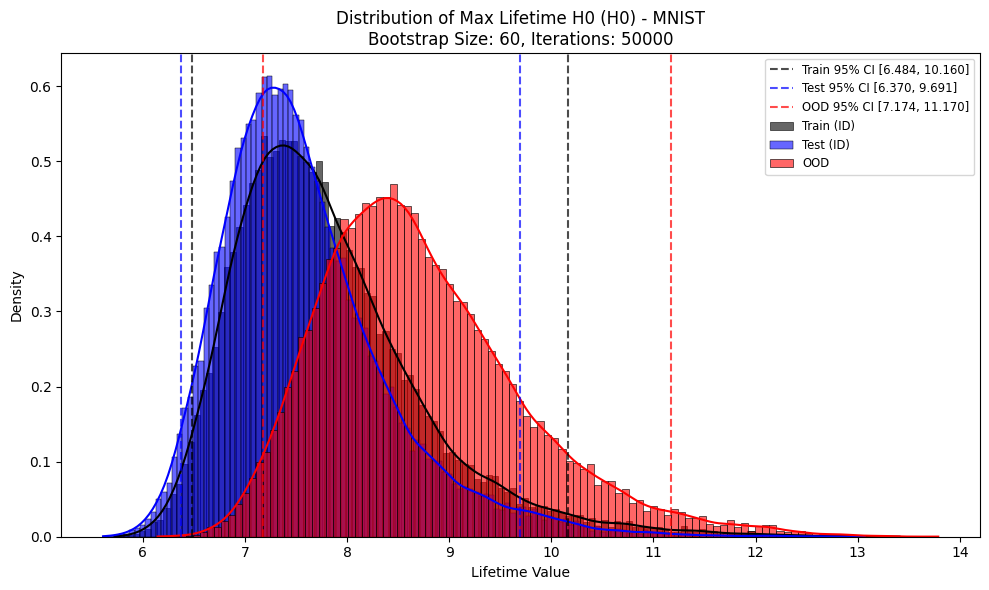

Saved plot: plots/MNIST_avg_lifetime_h1_ss60_iter50000_avg_h1.png


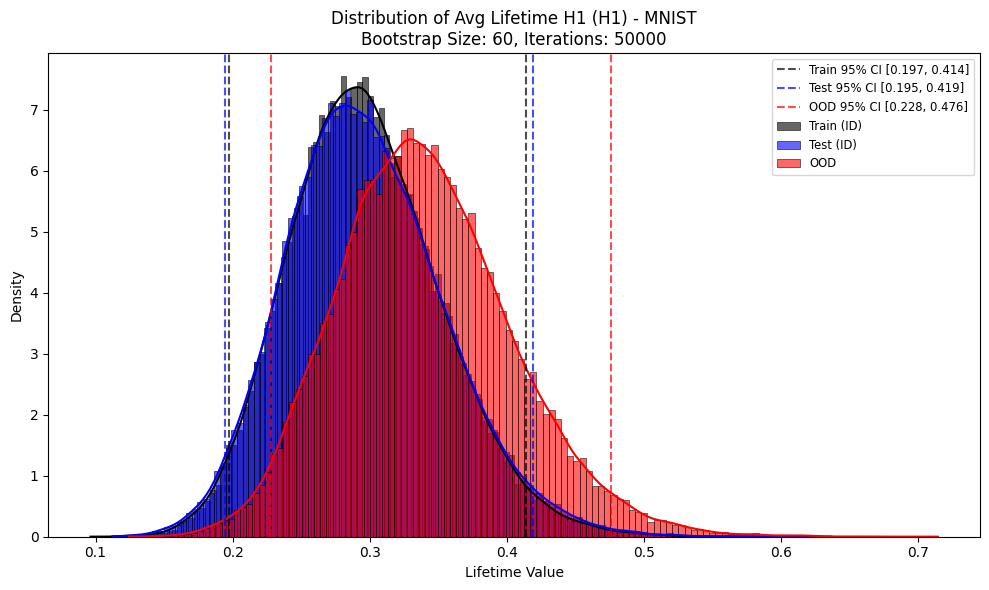

Saved plot: plots/MNIST_max_lifetime_h1_ss60_iter50000_max_h1.png


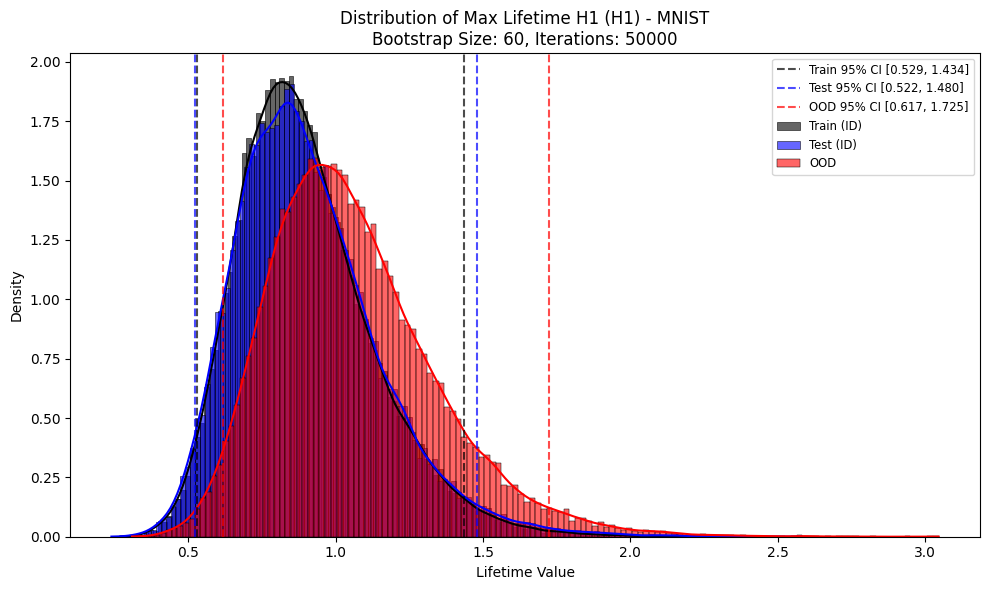

In [ ]:
print("Plotting MNIST results...")
plot_distributions(results_mnist_train, results_mnist_test, results_emnist_ood,
                   'avg_lifetime_h0', 'MNIST', SAMPLE_SIZE, 'avg_h0')
plot_distributions(results_mnist_train, results_mnist_test, results_emnist_ood,
                   'max_lifetime_h0', 'MNIST', SAMPLE_SIZE, 'max_h0')
plot_distributions(results_mnist_train, results_mnist_test, results_emnist_ood,
                   'avg_lifetime_h1', 'MNIST', SAMPLE_SIZE, 'avg_h1')
plot_distributions(results_mnist_train, results_mnist_test, results_emnist_ood,
                   'max_lifetime_h1', 'MNIST', SAMPLE_SIZE, 'max_h1')

## 10. Run Analysis: CIFAR-10 vs CIFAR-100

### 10.1 Load Model and Data (CIFAR)

In [ ]:

print("\n--- Starting CIFAR-10 Analysis ---")
# Load model
cifar_model = get_resnet18_model(num_classes=10, grayscale=False, pretrained=True) # CIFAR-10 has 10 classes
# Register hook
hook_handle_cifar = cifar_model.avgpool.register_forward_hook(get_activation('avgpool_cifar'))
target_layer_cifar = 'avgpool_cifar'

# Load data
cifar10_train_loader, cifar10_test_loader, cifar100_loader = load_cifar_data(BATCH_SIZE)
cifar10_train_loader, cifar10_test_loader, svhn_ood_loader = load_cifar10_svhn_data(BATCH_SIZE)

print("Extracting CIFAR-10 Train embeddings...")
cifar10_train_embeddings, _ = extract_embeddings(cifar_model, cifar10_train_loader, hook_handle_cifar, target_layer_cifar, N_SAMPLES_EMBEDDING, desc="CIFAR-10 Train")
hook_handle_cifar = cifar_model.avgpool.register_forward_hook(get_activation(target_layer_cifar)) # Re-register hook

print("Extracting CIFAR-10 Test embeddings...")
cifar10_test_embeddings, _ = extract_embeddings(cifar_model, cifar10_test_loader, hook_handle_cifar, target_layer_cifar, N_SAMPLES_EMBEDDING, desc="CIFAR-10 Test")
hook_handle_cifar = cifar_model.avgpool.register_forward_hook(get_activation(target_layer_cifar)) # Re-register hook

print("Extracting CIFAR-100 (OOD) embeddings...")
cifar100_ood_embeddings, _ = extract_embeddings(cifar_model, cifar100_loader, hook_handle_cifar, target_layer_cifar, N_SAMPLES_EMBEDDING, desc="CIFAR-100 OOD")


# print("Extracting EMNIST (OOD) embeddings...")
# emnist_ood_embeddings, _ = extract_embeddings(cifar_model, emnist_loader, hook_handle_cifar, target_layer_cifar, N_SAMPLES_EMBEDDING, desc="EMNIST OOD")

# print("Extracting SVHN (OOD) embeddings...")
# svhn_ood_embeddings, _ = extract_embeddings(cifar_model, svhn_ood_loader, hook_handle_cifar, target_layer_cifar, N_SAMPLES_EMBEDDING, desc="SVHN OOD")
# # Hook is removed automatically by the function

In [ ]:
print("Running Bootstrap Analysis for CIFAR-10...")
results_cifar10_train = run_bootstrap_analysis(cifar10_train_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="CIFAR-10 Train")
results_cifar10_test = run_bootstrap_analysis(cifar10_test_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="CIFAR-10 Test")
results_cifar100_ood = run_bootstrap_analysis(cifar100_ood_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="CIFAR-100 OOD")
# results_svhn_ood = run_bootstrap_analysis(svhn_ood_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="CIFAR-100 OOD")
# results_emnist_ood = run_bootstrap_analysis(emnist_ood_embeddings, N_ITERATIONS, SAMPLE_SIZE, MAX_DIM_HOMOLOGY, desc="CIFAR-100 OOD")


In [ ]:
print("Plotting CIFAR-10 results...")
plot_distributions(results_cifar10_train, results_cifar10_test, results_cifar100_ood,
                   'avg_lifetime_h0', 'CIFAR', SAMPLE_SIZE, 'avg_h0')
plot_distributions(results_cifar10_train, results_cifar10_test, results_cifar100_ood,
                   'max_lifetime_h0', 'CIFAR', SAMPLE_SIZE, 'max_h0')
plot_distributions(results_cifar10_train, results_cifar10_test, results_cifar100_ood,
                   'avg_lifetime_h1', 'CIFAR', SAMPLE_SIZE, 'avg_h1')
plot_distributions(results_cifar10_train, results_cifar10_test, results_cifar100_ood,
                   'max_lifetime_h1', 'CIFAR', SAMPLE_SIZE, 'max_h1')

## 11. Conclusion
This notebook demonstrated how to perform topological data analysis on neural network embeddings to compare in-distribution (Train/Test) and out-of-distribution (OOD) data, replicating the methodology from the paper.

Key findings often show that OOD data tends to have longer average lifetimes for $H_0$ features compared to ID data, suggesting the network struggles to "simplify" the topology of unfamiliar inputs. The separation might be less clear for $H_1$ or maximum lifetime statistics.

**Next Steps:**
* Increase `N_ITERATIONS` and `SAMPLE_SIZE` for more robust results closer to the paper's findings.
* Experiment with different pre-trained models or train models from scratch on MNIST/CIFAR-10.